In [76]:
# Import modelflow

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
%matplotlib inline

from ipywidgets import interact,Dropdown,Checkbox
from IPython.display import display, clear_output,Latex, Markdown
import pandas as pd

import modeljupyter as mj
from modelvis import waterplot

from modelinvert import targets_instruments
from modelclass import model
model.widescreen()



In [62]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [63]:
# Load model and data, and run 

if not 'masia' in locals():
    print('Load model')
    masia,baseline = model.modelload('Asia.pcim',run=1,silent=1)
from inject import inject
inject(masia)    

In [64]:
co2_input_var = [var for var in masia.totgraph.predecessors('WLD_CO2') if var.endswith('CO2')]
co2_input_var_asean = [var for var in masia.totgraph.predecessors('WLD_CO2') if var.endswith('CO2') and  var.split('_')[0] in masia.countries_ASEAN ]

In [65]:
co2_baseline = baseline.loc[:,co2_input_var].pipe(lambda df:df.rename(columns={c : masia.iso_dict.get(cname := c.split('_')[0],cname) for c in df.columns}))
co2_baseline_asean = baseline.loc[:,co2_input_var_asean].pipe(lambda df:df.rename(columns={c : masia.iso_dict.get(cname := c.split('_')[0],cname) for c in df.columns}))

In [66]:
# Variables to inputwidget

outvar = 'GDI GCARBR CO2 LNN'.split()
displayvar = 'WLD_CO2 ASP_CO2 G20_CO2 '

#  masia.countries_GCARBR_A is list of all countries in the model with a countries_GCARBR_A 
#  masia.countries_ASEAN is list of all countries in ASEAN 
countries_rest = [country for country in masia.countries_GCARBR_A if country not in masia.countries_ASEAN]

slidedef_allasean =  {'All ASEAN countries' : {'var': ' '.join([f'{country}_GCARBR_A' for country in masia.countries_ASEAN ])
                          , 'value': 0.0,'min':0,'max':100,'op':'+impulse','step':10,'dec':0}}
slidedef_allrest =  {'Rest of the world' : {'var': 
    ' '.join([f'{country}_GCARBR_A' for country in countries_rest])
                          , 'value': 0.0,'min':0,'max':100,'op':'+impulse','step':10,'dec':0}}
slidedef_countries = {masia.iso_dict.get(country,country)+', Extra' : 
                      {'var': f'{country}_GCARBR_A', 'value': 0.0,'min':-40,'max':40,'op':'+impulse','step':10,'dec':0} 
                      for country in  masia.countries_ASEAN}

slidedef = {**slidedef_allasean,**slidedef_allrest,**slidedef_countries}

# World $CO^2$

# ASEAN $CO^2$

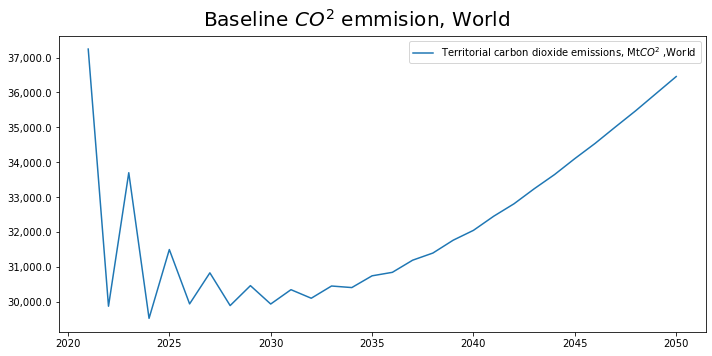

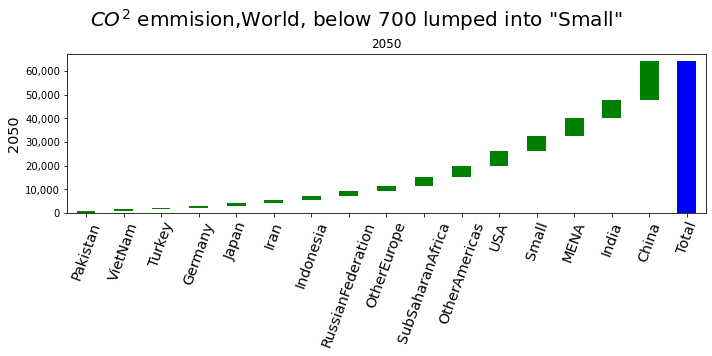

In [67]:
masia['wld_co2'].rename().plot(colrow=1,title='Baseline $CO^2$ emmision, World',top=0.9,ysize=5);

threshold =700
waterplot(co2_baseline.loc[[2050],:].T,autosum=1,threshold = 700,allsort=1,title = f'$CO^2$ emmision,World, below {threshold} lumped into "Small"',top=0.85);

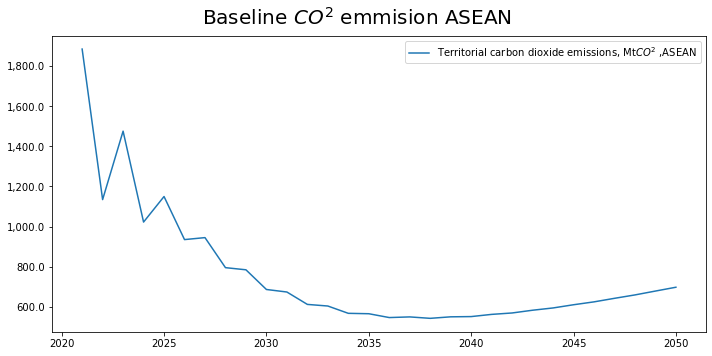

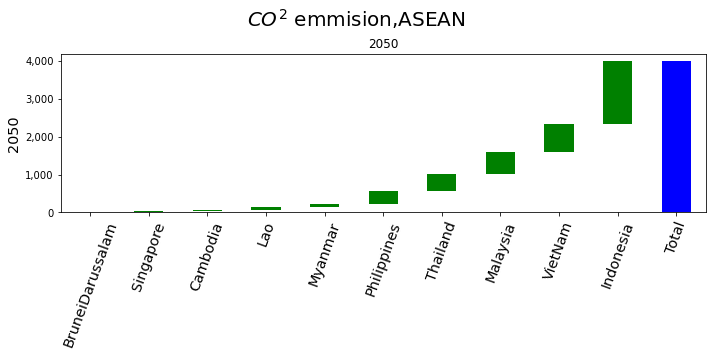

In [68]:
masia['asean_co2'].rename().plot(colrow=1,title='Baseline $CO^2$ emmision ASEAN',top=0.9,ysize=5);

threshold =0.1
waterplot(co2_baseline_asean.loc[[2050],:].T,autosum=1,threshold = 0 ,allsort=1,title = f'$CO^2$ emmision,ASEAN',top=0.85);

# Make some policy 

In [69]:
inject(masia)
input = masia.inputwidget_asia(2021,2050,slidedef=slidedef
                   ,showout=True,varpat=displayvar,showvar=True,go_now=1)

# World reducuction 

# ASEAN reduction

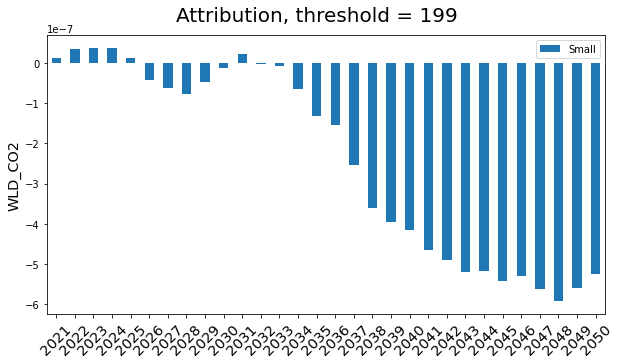

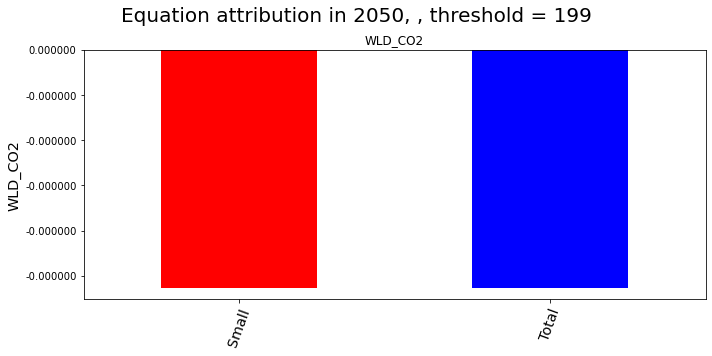

In [79]:
Threshold =199
masia.dekomp_plot('WLD_CO2',pct=0,threshold=Threshold,nametrans=masia.country_get)
masia.dekomp_plot_per('WLD_CO2',pct=0,threshold=Threshold,per=2050,sort=True,nametrans=masia.country_get);


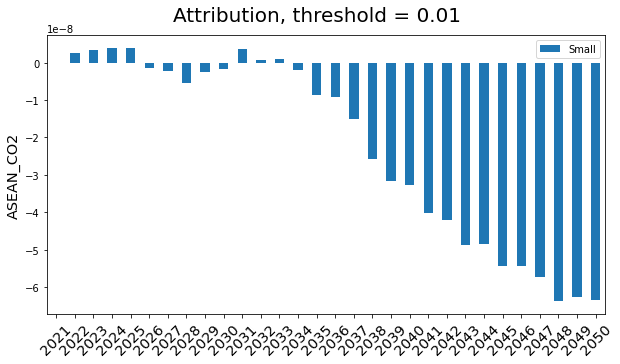

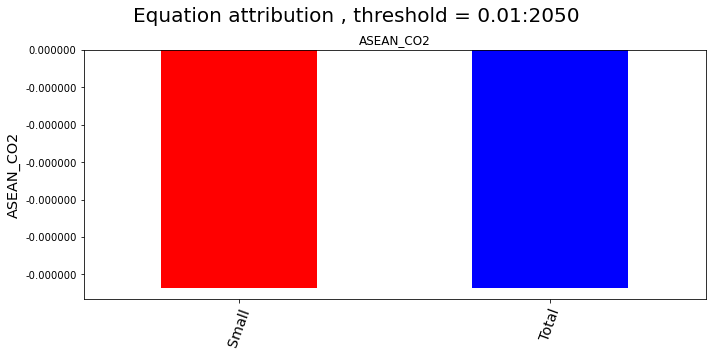

In [78]:

Threshold =0.01
masia.dekomp_plot('ASEAN_CO2',pct=0,threshold=Threshold,nametrans=masia.country_get)
masia.dekomp_plot_per('ASEAN_CO2',pct=0,threshold=Threshold,per=2050,sort=True,nametrans=masia.country_get);


# Inversion of the model

In [191]:
masia.lastdf = masia.basedf.copy()
instruments = [[f'{country}_GCARBR_A' for country in masia.countries_GCARBR_A]]

In [192]:
target = pd.DataFrame([36_440],index=[2050],columns=['WLD_CO2'])

In [193]:
delay = 2050-2021 

In [194]:
t_i = targets_instruments(databank=baseline,targets=target,instruments=instruments,model=masia,DefaultImpuls=300.,defaultconv=1000,varimpulse=True,nonlin=True)

In [195]:
t_i.jacobi(2050,29)

,Instrument_0
WLD_CO2,-20813.66166


In [183]:
masia,baseline = model.modelload('Asia.pcim',run=1,silent=1)
inject(masia)
masia.save=1
rate_var =  [f'{country}_GCARBR_A' for country in masia.countries_GCARBR_A]
for rate in list(range(0,360,50)):
    thisdf = baseline.copy()
    thisdf.loc[2021,rate_var] = thisdf.loc[2021,rate_var] + rate
    masia(thisdf,keep = f'{rate}',keep_variables='*_CO2')
    print(f'taxrate {rate}')

taxrate 0
taxrate 50
taxrate 100
taxrate 150
taxrate 200
taxrate 250
taxrate 300
taxrate 350


In [184]:
masia.keep_solutions.keys()

dict_keys(['0', '50', '100', '150', '200', '250', '300', '350'])

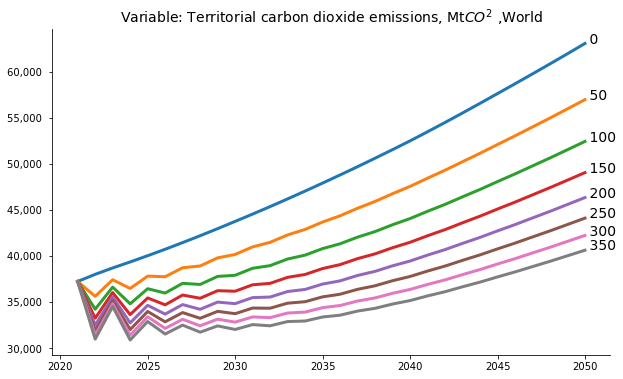

In [202]:
masia.keep_plot('wld_co2',legend=0) ; 


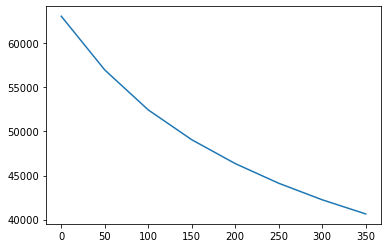

In [186]:
endvalues = pd.Series({rate:df.loc[2050,'WLD_CO2'] for rate,df in masia.keep_solutions.items()})
endvalues.plot();

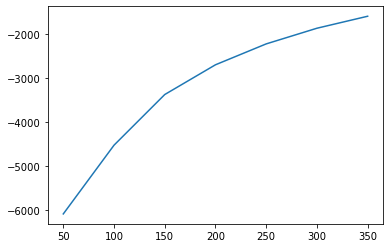

In [187]:
endvalues.diff().plot();

In [196]:
t_i.debug=1
res = t_i(delay=29)

Distance    :WLD_CO2   -26624.039974
Name: 2050, dtype: float64
OrgDistance :WLD_CO2   -26624.039974
Name: 2050, dtype: float64
Instrument_0    1.279162
dtype: float64
Distance    :WLD_CO2   -3247.955049
Name: 2050, dtype: float64
OrgDistance :WLD_CO2   -3247.955049
Name: 2050, dtype: float64
Instrument_0    0.156049
dtype: float64
Distance    :WLD_CO2   -2050.955219
Name: 2050, dtype: float64
OrgDistance :WLD_CO2   -2050.955219
Name: 2050, dtype: float64
Instrument_0    0.098539
dtype: float64
Distance    :WLD_CO2   -1363.020001
Name: 2050, dtype: float64
OrgDistance :WLD_CO2   -1363.020001
Name: 2050, dtype: float64
Instrument_0    0.065487
dtype: float64
Distance    :WLD_CO2   -931.197277
Name: 2050, dtype: float64
OrgDistance :WLD_CO2   -931.197277
Name: 2050, dtype: float64


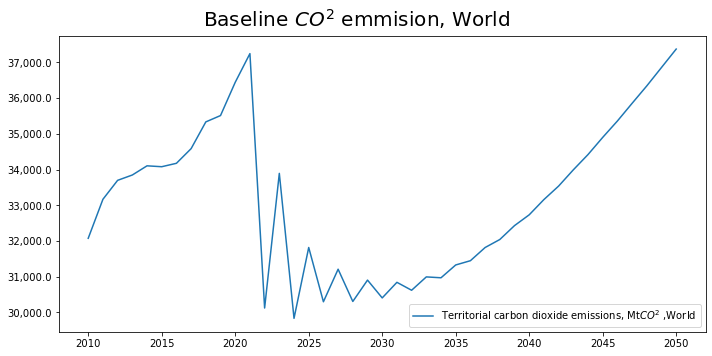

In [199]:
with masia.set_smpl(2010,2050):
    masia['wld_co2'].rename().plot(colrow=1,title='Baseline $CO^2$ emmision, World',top=0.9,ysize=5);


In [201]:
masia.exodif()

,AFG_GCARBR_A,ARM_GCARBR_A,AUS_GCARBR_A,AZE_GCARBR_A,BGD_GCARBR_A,BRN_GCARBR_A,BTN_GCARBR_A,CHN_GCARBR_A,FJI_GCARBR_A,FSM_GCARBR_A,...,THA_GCARBR_A,TJK_GCARBR_A,TKM_GCARBR_A,TLS_GCARBR_A,TON_GCARBR_A,TUR_GCARBR_A,UZB_GCARBR_A,VNM_GCARBR_A,VUT_GCARBR_A,WSM_GCARBR_A
2021,479.770991,479.770991,479.770991,479.770991,479.770991,479.770991,479.770991,479.770991,479.770991,479.770991,...,479.770991,479.770991,479.770991,479.770991,479.770991,479.770991,479.770991,479.770991,479.770991,479.770991
